# Steepest descent (analysis of step size)

Given the following cost function to optimize:
$$J = \frac{1}{2} ||\mathbf{d} - \mathbf{G} \mathbf{m}||_2^2 $$

Here we want to investigate the convergence speed of steepest descent (full gradient) and stochastic gradient descent.


- Gradient descent:
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\mathbf{r} = \mathbf{G}^T(\mathbf{d} - \mathbf{G}\mathbf{m})$, $\frac{dJ}{d\mathbf{m}} = \mathbf{r}$, $\alpha = const$
    

- Steepest descent (faster due to analytical line search):
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha_{k+1} \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\alpha = \frac{\mathbf{r}^T \mathbf{r}}{\mathbf{r}^T  \mathbf{G}^H \mathbf{G} \mathbf{r}}$
    
- Stochastic gradient descent

    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha \frac{dJ_b}{d\mathbf{m}_{k}} $$

    where $\mathbf{r}_b = \mathbf{G}_b^T(\mathbf{d}_b - \mathbf{G}_b\mathbf{m})$, $\frac{dJ_b}{d\mathbf{m}} = \mathbf{r}_b$ with $\mathbf{G}_b$ and $\mathbf{d}_b$ are a row selection of $\mathbf{G}$ and $\mathbf{d}$ (with size of the batch), $\alpha = const$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pylops import *
from stochmdd.steepest import *
from stochmdd.stochmdd_numpy import SGD

plt.style.use('default')  # seaborn-whitegrid, ggplot, bmh

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('text', usetex=True)

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rc('font', weight='bold')  # fontsize of the figure title

np.random.seed(10)

Let's start by setting up the forward problem. 

We also compute the condition number of the operator $\mathbf{G}$ - note: the further the conditioning number from 1 the further the behaviour of the two solvers we will use in the following

In [2]:
m = np.array([1, 1])
G = np.random.uniform(0, 50, (50, 2))

print('G^T G', G.T @ G)
Gop = MatrixMult(G)
d = Gop @ m
L = np.linalg.eig(G.T @ G)[0].max()

print('d', d)
print('G eigenvalues', np.linalg.eig(G.T @ G)[0])
print('G condition number %f' % np.linalg.cond(G.T @ G))

G^T G [[37930.09734011 28772.99424738]
 [28772.99424738 39863.79651646]]
d [39.60362963 69.12260587 36.16518289 47.92967885 12.87253254 81.93765823
 25.80702649 71.25735142 50.68156928 81.6174953  34.23572078 52.37371876
 43.79235839 56.54526105 62.57180677 66.34351746 61.39424849 19.5579703
 47.13328441 33.65917339 68.34365758 52.78989211 55.31501655 58.99490932
 24.52637678 24.29948093 48.61288387 66.41875805 72.1965011  53.8748489
 75.01017043 56.23796559 19.82317629 19.25365042 55.22748041 23.47256936
 47.57090075 19.47222531 82.15778808 64.78028933 55.95220959 43.00261545
 16.31355455 27.2569218  56.15426043 38.39651119 52.15351032 41.73782373
 70.89272754 41.90348957]
G eigenvalues [10107.71289738 67686.18095919]
G condition number 6.696488


In [3]:
# cost function grid
nm1, nm2 = 51, 51
m_min, m_max = (m[0] - 1.2, m[1] - 1.2), (m[0] + 1.2, m[1] + 1.2)
m1, m2 = np.mgrid[m_min[0]:m_max[0]:1j*nm1, m_min[1]:m_max[1]:1j*nm2]
mgrid = np.vstack((m1.ravel(), m2.ravel()))

J = 0.5 * np.sum(mgrid * (G.T @ G @ mgrid), axis=0) - (mgrid.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
J = J.reshape(nm1, nm2)

## Steepest descent

[1. 1.]


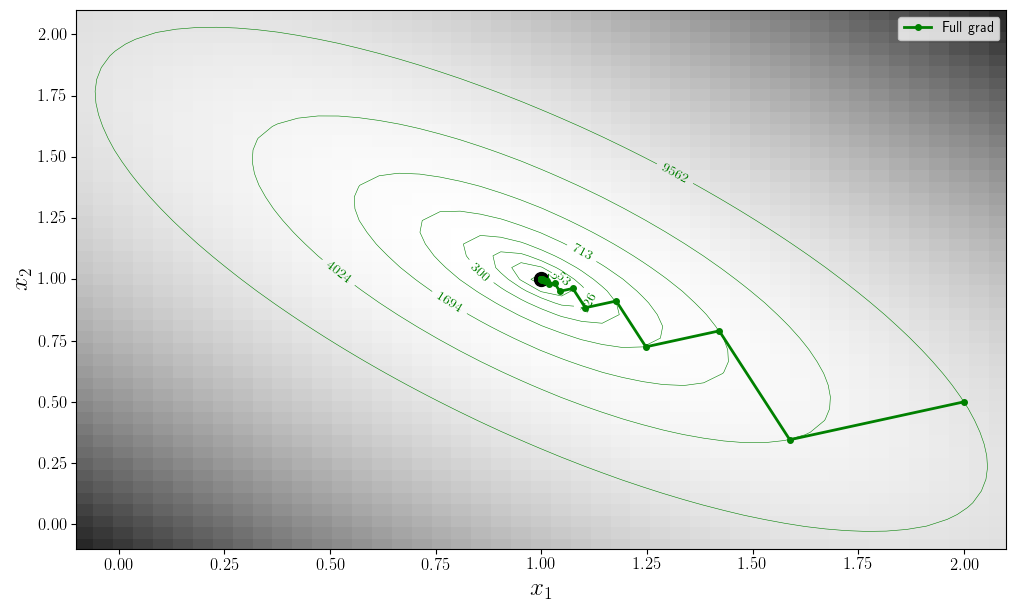

In [4]:
m0 = np.array([m[0]+1, m[1]-0.5])

# analytical stepsize
#msdana, rsdana, alphaana = steepest_descent(Gop.H @ Gop, Gop.H @ d, 
#                                            niter=50, m0=m0, a=None, tol=1e-3)
msdana, rsdana, alphaana = steepest_descent1(Gop, d, 
                                             niter=50, m0=m0, a=None, tol=0)
msdana = msdana.T
print(msdana[:, -1])

# cost function at solution
Jsdana = 0.5 * np.sum(msdana * (G.T @ G @ msdana), axis=0) - (msdana.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(msdana[0], msdana[1], '.-g', lw=2, ms=8, label='Full grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

## Full gradient

In [5]:
def gradfun(self, y, x):
        r = y - self._matvec(x)
        loss = np.linalg.norm(r) ** 2
        g = -self._rmatvec(r)
        return g, loss
    
Gop.grad = gradfun

In [6]:
xfgd = np.array([m[0]+1, m[1]-0.5])
xfgd_hist = [xfgd.copy(), ]
rfgd = [np.linalg.norm(Gop.H @(d - Gop @ xfgd)), ]
optimizer = SGD(xfgd, 1./L)

for it in range(40):

    # Compute gradient
    grad, loss = Gop.grad(Gop, d.ravel(), xfgd)

    # Update model
    optimizer.step(grad)
    
    xfgd_hist.append(xfgd.copy())
    rfgd.append(np.linalg.norm(Gop.H @(d - Gop @ xfgd)))
    
xfgd_hist = np.vstack(xfgd_hist).T
print(xfgd_hist[:, -1])


[1.00118851 0.99885076]


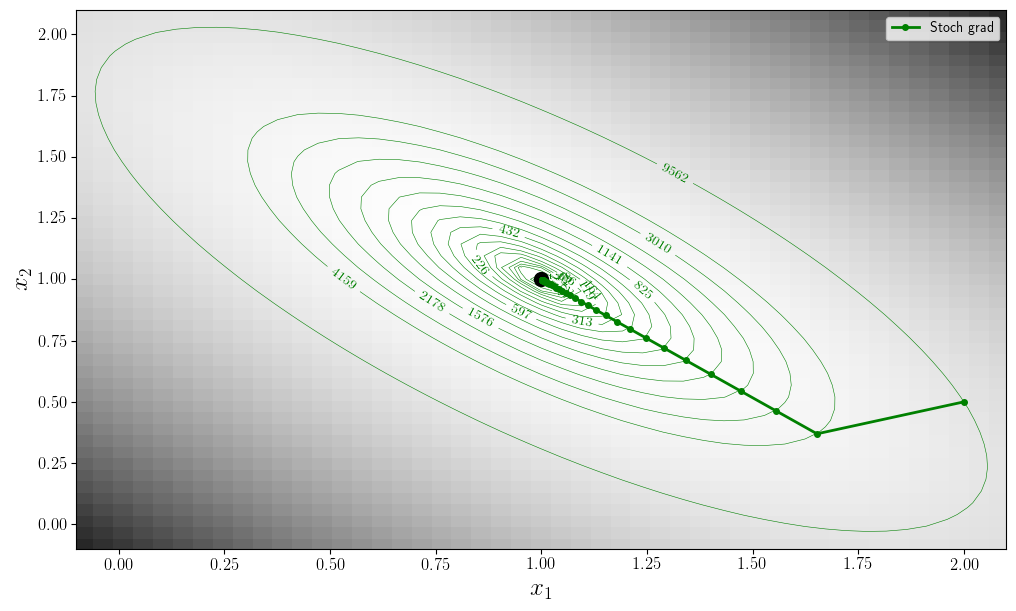

In [7]:
# cost function at solution
Jsdana = 0.5 * np.sum(xfgd_hist * (G.T @ G @ xfgd_hist), axis=0) - (xfgd_hist.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xfgd_hist[0], xfgd_hist[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

## Stochastic gradient

In [8]:
# Now we use batches
xsgd = np.array([m[0]+1, m[1]-0.5])
xsgd_hist = [xsgd.copy(), ]
rsgd = [np.linalg.norm(Gop.H @(d - Gop @ xsgd)), ]
#optimizer = SGD(xsgd, 1/L)#1.4e-5)
optimizer = SGD(xsgd, 1e-4) # select LR 10 times higher than theory of FG allows 1/L

batches = np.random.permutation(np.arange(d.size)).reshape(d.size//5, 5).astype(np.int)

for it in range(10):
    for batch in batches:
        #Make data and operator
        Gop1 = MatrixMult(G[batch])
        Gop1.grad = gradfun
        d1 = d[batch]
        
        # Compute gradient
        grad, loss = Gop1.grad(Gop1, d1, xsgd)

        # Update model
        optimizer.step(grad)

        xsgd_hist.append(xsgd.copy())
        rsgd.append(np.linalg.norm(Gop.H @(d - Gop @ xsgd)))

xsgd_hist = np.vstack(xsgd_hist).T
xsgd_hist_epochs = xsgd_hist[:, ::batches.shape[0]]
print(xsgd_hist[:, -1], xsgd_hist.shape)

[1.00001389 0.99998171] (2, 101)


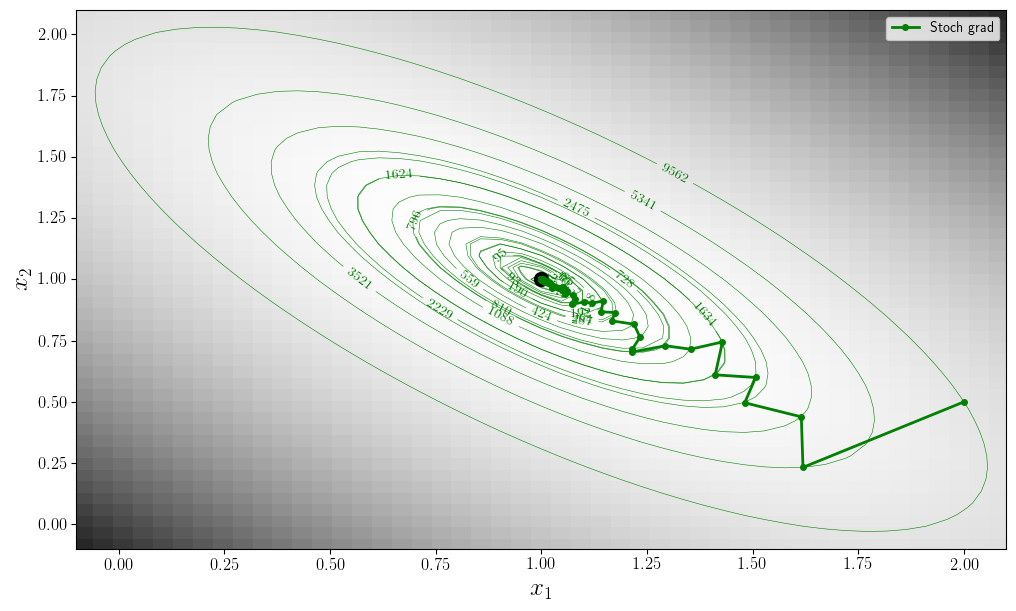

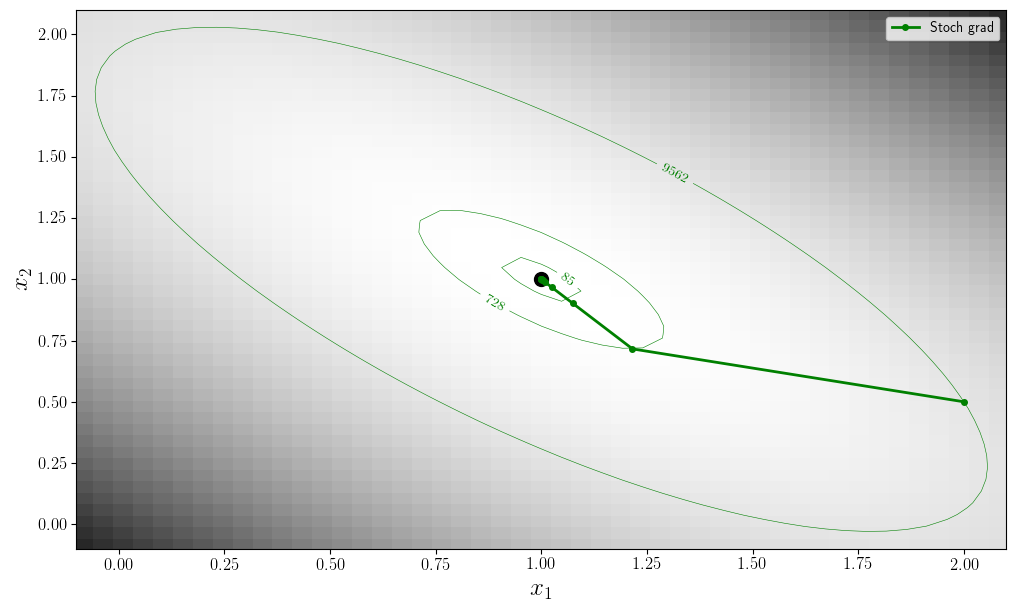

In [9]:
# cost function at solution
Jsdana = 0.5 * np.sum(xsgd_hist * (G.T @ G @ xsgd_hist), axis=0) - (xsgd_hist.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xsgd_hist[0], xsgd_hist[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

# cost function at solution
Jsdana = 0.5 * np.sum(xsgd_hist_epochs * (G.T @ G @ xsgd_hist_epochs), axis=0) - (xsgd_hist_epochs.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xsgd_hist_epochs[0], xsgd_hist_epochs[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

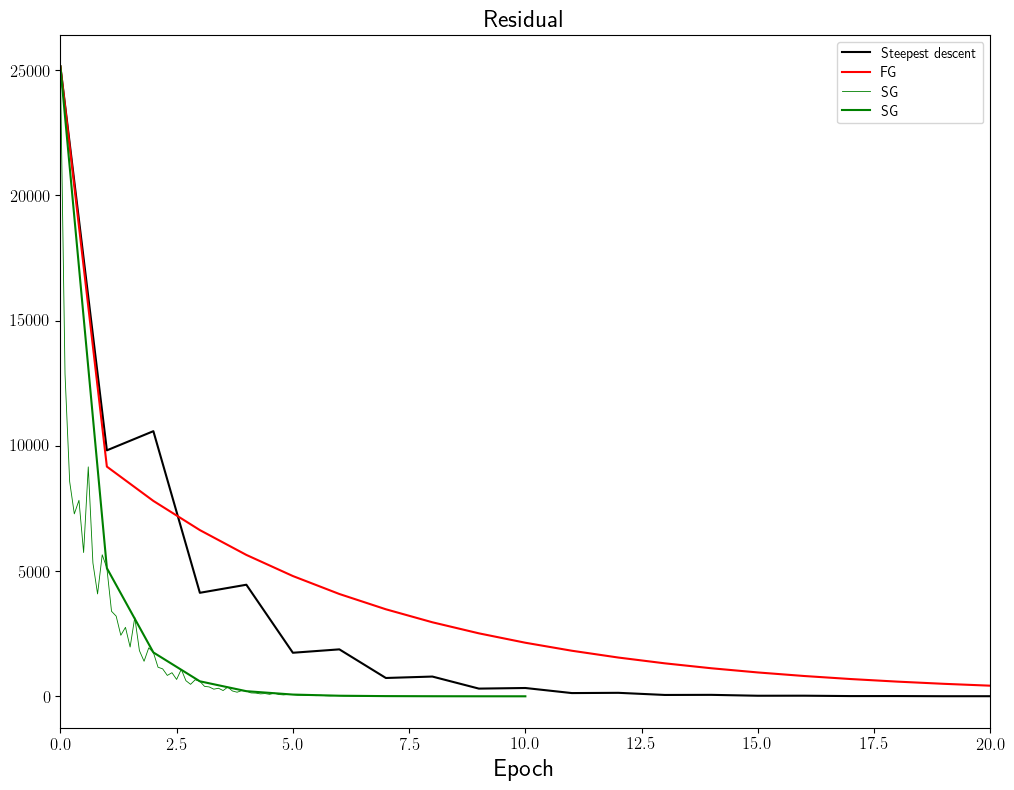

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(rsdana, 'k', label='Steepest descent')
plt.plot(rfgd, 'r', label='FG')
plt.plot(np.linspace(0,10,10*batches.shape[0]+1), rsgd, 'g', lw=0.6)
plt.plot(rsgd[::batches.shape[0]], 'g', label='SG')
plt.xlabel('Epoch')
plt.title('Residual')
plt.xlim(0,20)
plt.legend();